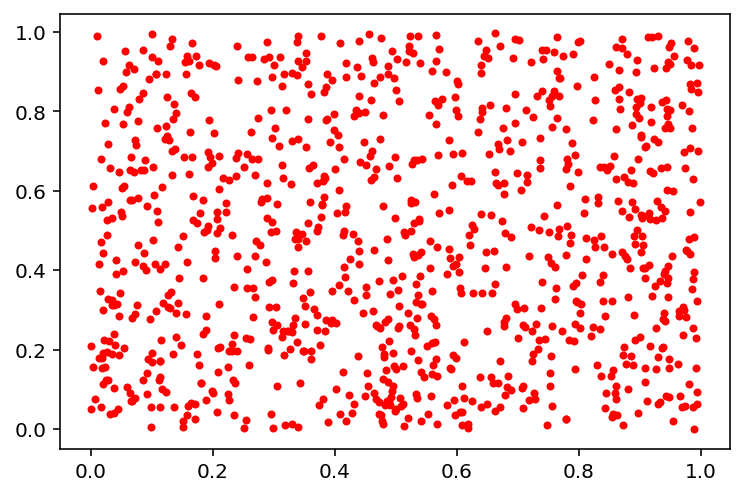

In [3]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

def make_data(n_points, radius):

    xs = np.random.random(n_points)
    ys = np.random.random(n_points)

    area = (max(xs) - min(xs)) * (max(ys) - min(ys))

    d = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(n_points):
            d[i,j] = np.sqrt((xs[i] - xs[j])**2 + (ys[i]-ys[j])**2)

    r = d < 2*radius
    r = r.astype(float)
    r = r - np.identity(n_points)

    return r, xs, ys

np.random.seed(929)
radius = 0.1
r, xs, ys = make_data(1000, radius)
plt.plot(xs, ys, '.r')

In [4]:
# A) use one with largest intersection

def greedy_max_points_with_rejection(r):
    r = r.copy()
    n_points = r.shape[0]
    initial = np.sum(r, axis=1)

    #identity is added to make sure it doesn't keep choosing the current one
    n_points = r.shape[0]
    r = (r + np.identity(n_points)).astype(int)

    selected = []
    
    #pick minimum rejection for the first soln
    total_banned = np.sum(r, axis=1)
    initial = np.argmin(total_banned)
    selected.append(initial)
    current_banned = r[initial].copy()
    r[r[initial].astype(bool), :] = -1
    
    #pick maximum intersection for all others
    while np.sum(current_banned) != n_points:
        intersections = r @ current_banned
        best_one = np.argmax(intersections)
        selected.append(best_one)
        current_banned = current_banned | r[best_one]
        r[r[best_one].astype(bool), :] = -1

    result = np.zeros(n_points)
    result[selected] = 1
    return result

sol = greedy_max_points_with_rejection(r)
print(sum(sol))

24.0


Text(0.5, 1.0, 'Greedy with maximum intersection(<100ms)')

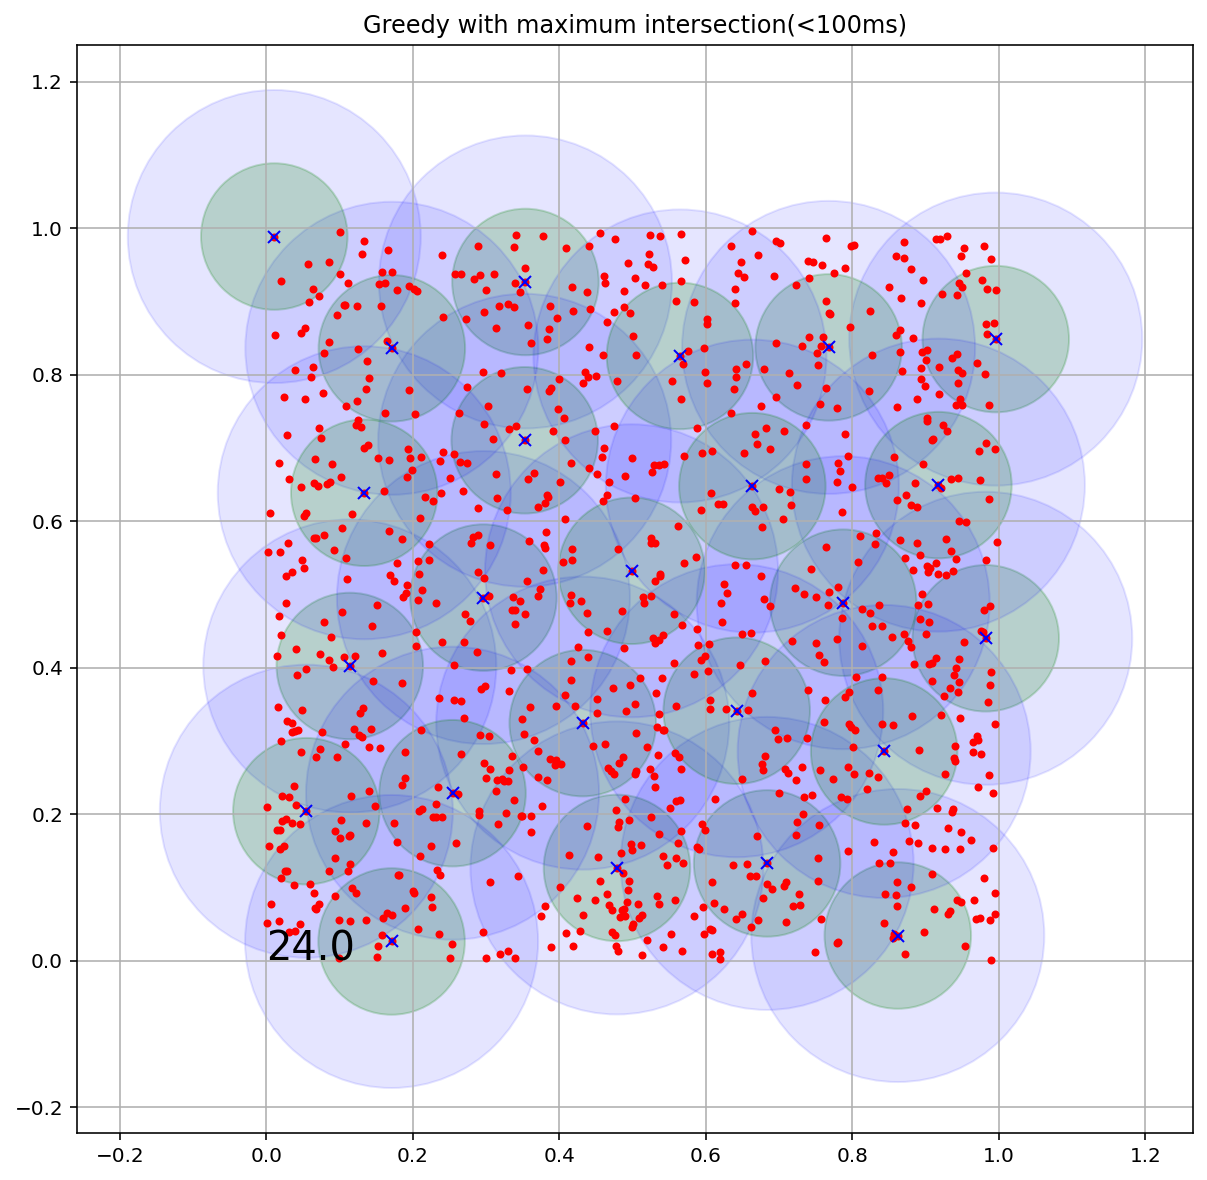

In [5]:
def visualize(xs, ys, sol, radius):
    x=sol
    #print(x)
    plt.figure(figsize=(10,10))
    plt.plot(xs, ys, '.r')
    for i, v in enumerate(x):
        if v > 0.5:
            plt.plot(xs[i], ys[i], 'xb')
            circle = plt.Circle((xs[i], ys[i]), radius*2, alpha=0.1, color='blue')
            plt.gca().add_patch(circle)
            circle = plt.Circle((xs[i], ys[i]), radius, alpha=0.2, color='green')
            plt.gca().add_patch(circle)
    plt.annotate(f'{np.sum(sol)}', (0,0), size=20)
    plt.axis('equal')
    plt.grid()
    
visualize(xs, ys, sol, radius)
plt.title('Greedy with maximum intersection(<100ms)')

70 655
111 912
151 455
186 277
227 537
262 659
305 934
347 555
384 400
425 793
451 38
491 719
521 736
553 386
598 29
645 66
685 695
725 114
732 211
759 301
807 355
845 952
881 628
920 183
941 169
988 292
1000 105


Text(0.5, 1.0, 'Greedy with maximum leftover (<100ms)')

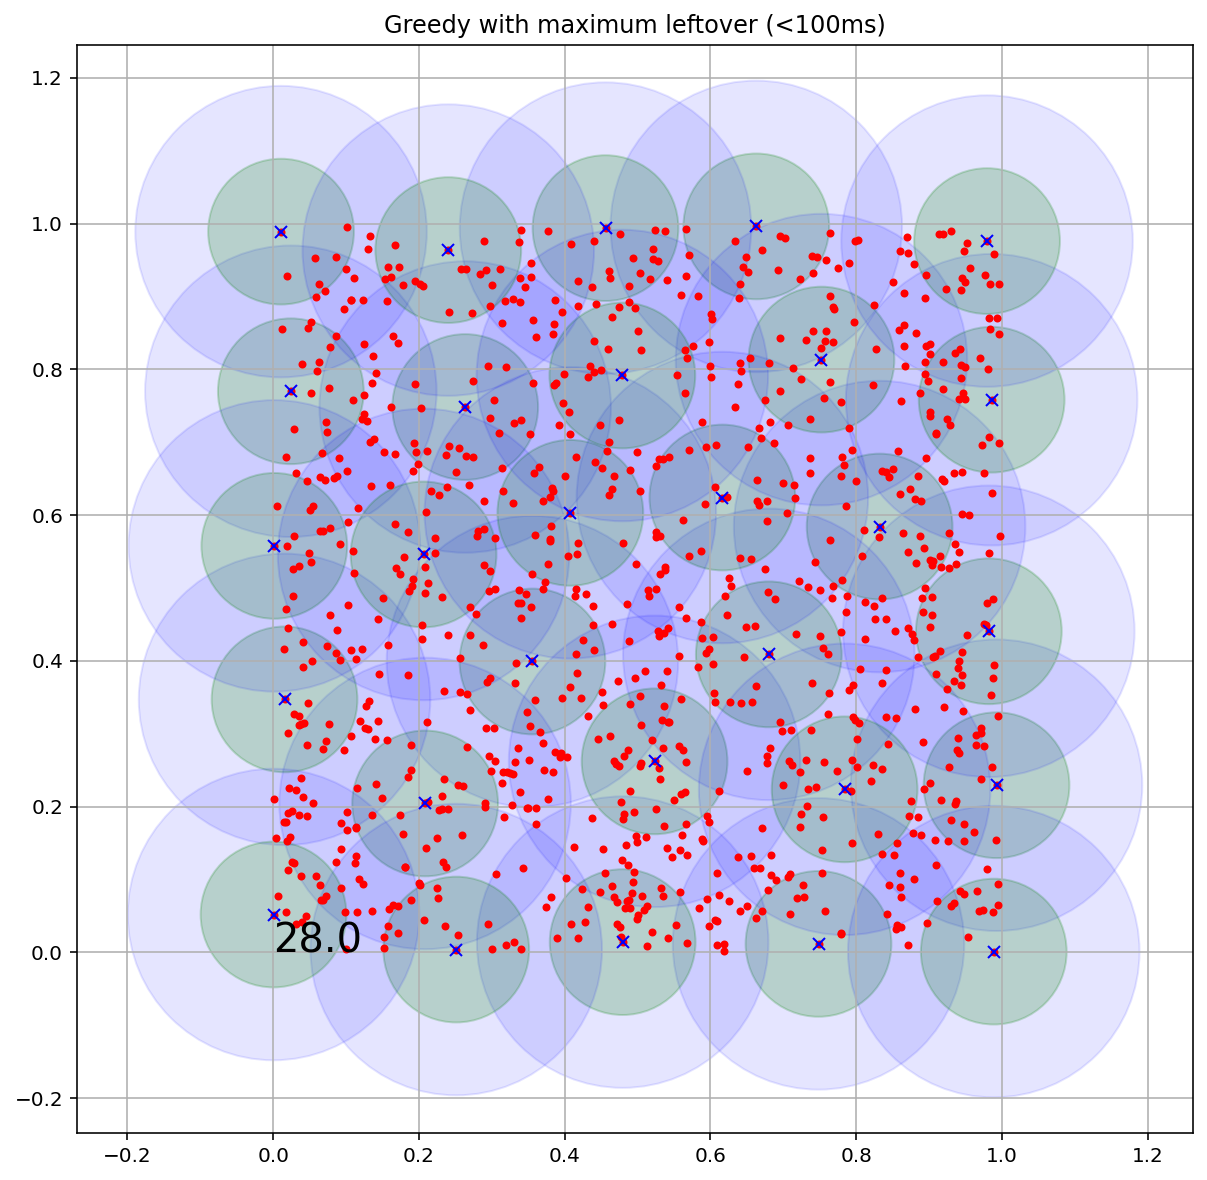

In [6]:
def greedy_max_left_over(r):
    r = r.copy()
    n_points = r.shape[0]
    initial = np.sum(r, axis=1)

    #identity is added to make sure it doesn't keep choosing the current one
    n_points = r.shape[0]
    r = (r + np.identity(n_points)).astype(int)

    selected = []
    
    #pick minimum rejection for the first soln
    total_banned = np.sum(r, axis=1)
    initial = np.argmin(total_banned)
    selected.append(initial)
    current_banned = r[initial].copy()
    r[r[initial].astype(bool), :] = n_points*2 +1
    
    #pick maximum intersection for all others
    while np.sum(current_banned) != n_points:
        tmp = r | current_banned
        #print(tmp)
        dead = np.sum(tmp, axis=1)
        best_one = np.argmin(dead)
        selected.append(best_one)
        current_banned = current_banned | r[best_one]
        r[r[best_one].astype(bool), :] = n_points*2+1
        print(np.sum(current_banned), best_one)

    result = np.zeros(n_points)
    result[selected] = 1
    return result

sol = greedy_max_left_over(r)
visualize(xs, ys, sol, radius)
plt.title('Greedy with maximum leftover (<100ms)')

In [8]:
#cvxpy cbc takes forever, it's correct though

# def max_points_with_rejection(r):
#     n_points = r.shape[0]
#     x = cp.Variable(n_points, boolean=True)
#     N = n_points # anything >> len(x)
#     weights = np.random.randn(n_points)*1e-3 + 1
#     prob = cp.Problem(cp.Maximize(weights@x),
#                      [
#                         (np.identity(n_points) + r / N) @ x <= 1,
#                          cp.sum(x) == 24 
#                         #cp.sum(x) <= area*0.74/np.pi/radius**2 # help cutting down soln in branch and bound
#                      ])
#     print(prob.solve(solver='CBC'))
#     return x.value

# x = max_points_with_rejection(original_r)
# print(x)

In [9]:
from ortools.linear_solver import pywraplp as pw
def max_points_with_rejection_ortools(r):
    solver = pw.Solver.CreateSolver('SCIP')
    n_points = r.shape[0]
    xvar = [solver.BoolVar(f'x[{i}]') for i in range(n_points)]
    N = n_points*300
    a = np.identity(n_points) + r / N
    for j in range(n_points):
        solver.Add( sum([c*x for c,x in zip(a[j], xvar)]) <= 1)
    #solver.Add(sum(xvar) == 22)
    solver.Maximize(sum(xvar))
    solver.Solve()
    sol = np.array([x.solution_value() for x in xvar])
    return sol

In [10]:
sol = max_points_with_rejection_ortools(r)

Text(0.5, 1.0, 'Optimal MILP Solution(1min)')

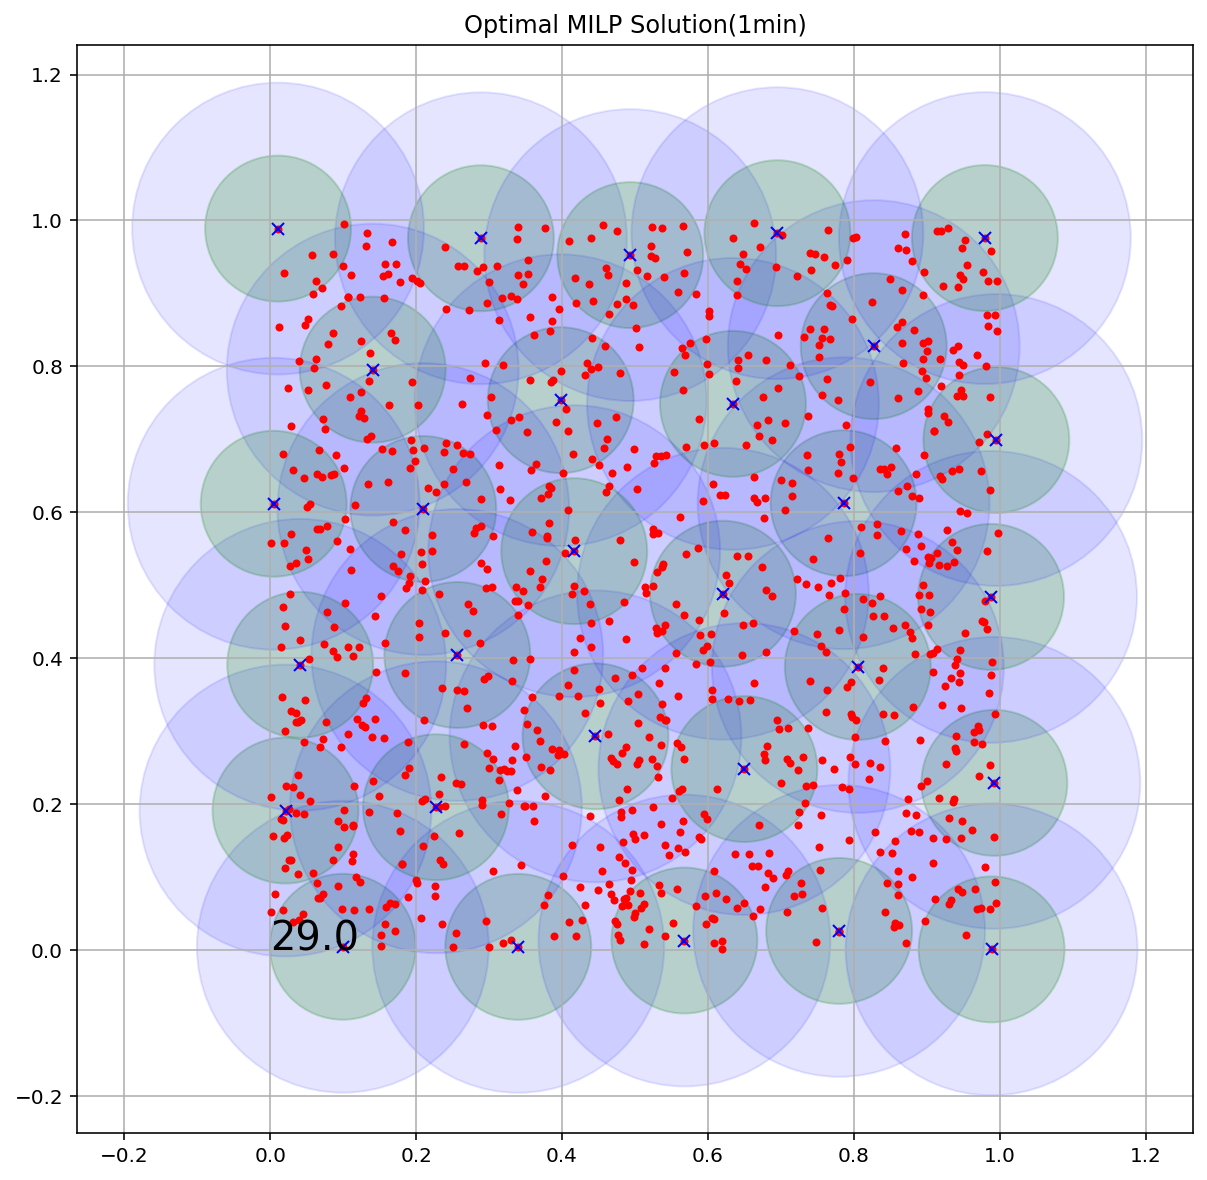

In [11]:
visualize(xs, ys, sol, radius)
plt.title('Optimal MILP Solution(1min)')